In [1]:
# imports
import sys
import pandas as pd
import numpy as np
sys.path.append('../../') # to access the files in higher directories
sys.path.append('../') # to access the files in higher directories
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import Data.data_provider as dp
import core as cal
from estimators.IR_RF_estimator import IR_RF

In [2]:
# params
calib_methods = ["RF", "Platt" , "ISO", "Rank", "CRF", "VA", "Beta", "Elkan", "tlr"]
metrics = ["acc", "auc", "brier", "ece", "logloss"]

data_name = "S_trees"

params = {
    "runs": 50,
    "n_tree": [2, 5, 10, 20, 40, 60, 80, 100], # as percentage of the x_calib data
    "data_size": 1000,
    "n_features": 20,
    "oob": False,
    "test_split": 0.3,
    "calib_split": 0.5
}

In [3]:
data_list = []
calib_results_dict = {}

for exp_trees in params["n_tree"]:

    # Data
    exp_data_name = str(exp_trees) # data_name + "_" + 
    data_list.append(exp_data_name)
    X, y, tp = dp.make_classification_gaussian_with_true_prob(params["data_size"], params["n_features"], 0)
    
    data_dict = {} # results for each data set will be saved in here.
    for seed in range(params["runs"]): # running the same dataset multiple times
        # split the data
        data = cal.split_train_calib_test(exp_data_name, X, y, params["test_split"], params["calib_split"], seed)

        # train model
        irrf = IR_RF(n_estimators=exp_trees, oob_score=params["oob"], random_state=seed)
        irrf.fit(data["x_train"], data["y_train"])

        # calibration
        res = cal.calibration(irrf, data, calib_methods, metrics) # res is a dict with all the metrics results as well as RF probs and every calibration method decision for every test data point
        data_dict = cal.update_runs(data_dict, res) # calib results for every run for the same dataset is aggregated in data_dict (ex. acc of every run as an array)
    calib_results_dict.update(data_dict) # merge results of all datasets together
tables = cal.mean_and_ranking_table(calib_results_dict, metrics, calib_methods, data_list, mean_and_rank=False)

Text(0, 0.5, 'ECE')

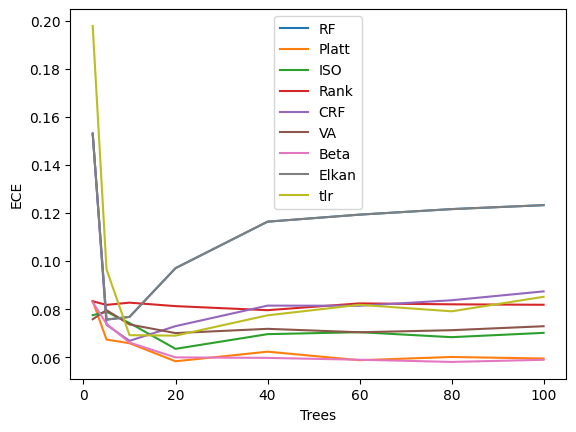

In [9]:
ax = tables["ece"].plot()
ax.set_xlabel("Trees")
ax.set_ylabel("ECE")